# Plot interactive

## Description

This program creates an interactive map to visualize the repeat station network distribution over Brazil

In [1]:
# Import modules
from pathlib import Path
import mestrado_module as mm
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
from folium import plugins
from shapely.geometry import Point, Polygon
import seaborn as sns

In [2]:
# Repeat stations data
rs_folder: Path = Path(mm.path_pipeline_03_rs_database_creation)
rs_file: Path = Path(mm.output_3_code_rs_database)

# Shapefile info
shapefile_folder: Path = Path(mm.path_brazil_shapefile)
shapefile_file: Path = Path(mm.brazil_shapefile)

# Output folder: output_data_analysis
output_folder: Path = Path(mm.path_pipeline_extra_01b_plot_maps)

# Maps
inter_map = "../02_pipeline/extra_01_plots/rs_maps/current_brazilian_repeat_station_network_map.html"
static_map: Path = Path("current_brazilian_repeat_station_network_map.png")

# Seaborn style
sns.set_style('darkgrid')

## Read Repeat Station database

In [3]:
# Load repeat station database with Pandas
df = pd.read_csv(rs_folder / rs_file)
df

Code  Lat_dd  Lon_dd    Alt_m   Time_dy    D_dd    I_dd     H_nT  \
0     AC_CZS  -7.637 -72.670  182.464  1958.529   2.683  11.281  29097.0   
1     AC_CZS  -7.637 -72.670  182.464  1965.848   1.824  11.277  28662.0   
2     AC_CZS  -7.620 -72.670  195.600  1978.640  -0.035  11.026  27835.0   
3     AC_CZS  -7.599 -72.770  196.508  1986.279  -1.343  10.685  27402.0   
4     AC_CZS  -7.599 -72.770  196.508  1989.503  -1.847  10.468  27222.0   
...      ...     ...     ...      ...       ...     ...     ...      ...   
1077  TO_PNL -10.727 -48.408  240.299  1985.119 -18.142  -7.084  24938.0   
1078  TO_PNL -10.727 -48.408  240.299  1986.670 -18.325  -7.556  24865.0   
1079  TO_PNL -10.727 -48.408  240.299  1995.817 -19.315 -10.562  24358.0   
1080  TO_PNL -10.721 -48.401  256.835  2003.702 -20.117 -13.008  23896.0   
1081  TO_RAB  -9.242 -48.530  249.440  1970.729 -16.148   0.093  26189.0   

         X_nT    Y_nT  ...  Region                  RS_name Y_value_was_NaN  \
0     29065.0  1362.0  ...       N         CRUZEIRO DO SUL               No   
1     28648.0   912.0  ...       N         CRUZEIRO DO SUL               No   
2     27835.0   -17.0  ...       N         CRUZEIRO DO SUL               No   
3     27394.0  -642.0  ...       N         CRUZEIRO DO SUL               No   
4     27208.0  -877.0  ...       N         CRUZEIRO DO SUL               No   
...       ...     ...  ...     ...                      ...             ...   
1077  23698.0 -7765.0  ...       N           PORTO NACIONAL              No   
1078  23604.0 -7817.0  ...       N           PORTO NACIONAL              No   
1079  22987.0 -8056.0  ...       N           PORTO NACIONAL              No   
1080  22438.0 -8218.0  ...       N           PORTO NACIONAL              No   
1081  25156.0 -7283.0  ...       N  RIBEIRAO DA AGUA BRANCA              No   

     Z_value_was_NaN Calculated_Y Calculated_Z TTB_distances_km  \
0                 No     1362.067     5804.269         2770.494   
1                 No      912.318     5715.412         2770.494   
2                 No      -17.004     5423.784         2770.044   
3                 No     -642.249     5170.325         2780.199   
4                 No     -877.391     5029.623         2780.199   
...              ...          ...          ...              ...   
1077              No    -7765.075    -3099.141         1058.862   
1078              No    -7817.785    -3298.293         1058.862   
1079              No    -8056.751    -4541.793         1058.862   
1080              No    -8218.967    -5520.486         1058.203   
1081              No    -7283.939       42.510          893.676   

      VSS_distances_km  Closest_OBS  N_occupations  
0             3511.151          TTB              6  
1             3511.151          TTB              6  
2             3512.127          TTB              6  
3             3522.772          TTB              6  
4             3522.772          TTB              6  
...                ...          ...            ...  
1077          1393.116          TTB              9  
1078          1393.116          TTB              9  
1079          1393.116          TTB              9  
1080          1393.470          TTB              9  
1081          1552.975          TTB              1  

[1082 rows x 23 columns]

## Keep only the lat and lon coordinates of the last occupation of each station

In [4]:
# Create new dataframe with only the "Code", "Lat_dd" and "Lon_dd" columns
plot_df = df.drop(
    columns=[
        "Alt_m",
        "Time_dy",
        "D_dd",
        "I_dd",
        "H_nT",
        "X_nT",
        "Y_nT",
        "Z_nT",
        "F_nT",
        "State",
        "Region",
        #        "RS_name",
        "Y_value_was_NaN",
        "Z_value_was_NaN",
        "Calculated_Y",
        "Calculated_Z",
        "TTB_distances_km",
        "VSS_distances_km",
    #    "Closest_OBS"
    ]
)

# Keep the register of one station occupation only
# plo_df.drop_duplicates(subset="Code", keep="first", inplace=True) # first occurence
plot_df.drop_duplicates(subset="Code", keep="last", inplace=True)  # last occurence

# New dataframe with information about lat and lon of each station
plot_df.reset_index(drop=True, inplace=True)
plot_df

Code  Lat_dd  Lon_dd                  RS_name Closest_OBS  \
0      AC_CZS  -7.599 -72.770         CRUZEIRO DO SUL          TTB   
1      AC_EPC -11.029 -68.739           EPITACIOLANDIA         TTB   
2    AC_EPC_B -11.040 -68.727         EPITACIOLANDIA B         TTB   
3      AC_RBC  -9.996 -67.802               RIO BRANCO         TTB   
4      AL_MCO  -9.512 -35.797                   MACEIO         VSS   
..        ...     ...     ...                      ...         ...   
213    SP_SJC -23.231 -45.863      SAO JOSE DOS CAMPOS         VSS   
214    SP_SPO -23.548 -46.742                SAO PAULO         VSS   
215    SP_TAU -23.038 -45.516                  TAUBATE         VSS   
216    TO_PNL -10.721 -48.401           PORTO NACIONAL         TTB   
217    TO_RAB  -9.242 -48.530  RIBEIRAO DA AGUA BRANCA         TTB   

     N_occupations  
0                6  
1                2  
2                1  
3               10  
4                9  
..             ...  
213              8  
214              8  
215              5  
216              9  
217              1  

[218 rows x 6 columns]

## Read Brazil shapefile

In [5]:
# Create a geodataframe with info from the shapefile
brazil_gdf = gpd.read_file(shapefile_folder / shapefile_file)
#brazil_gdf

In [6]:
# Get info from the geodataframe
brazil_gdf.info()

# Check the used projection in the shapefile (EPSG:4326 is the WGS84 latitude-longitude projection)
brazil_gdf.crs  # look here https://epsg.io/4674, projection used in latin america

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   CD_UF      27 non-null     object  
 1   NM_UF      27 non-null     object  
 2   SIGLA_UF   27 non-null     object  
 3   NM_REGIAO  27 non-null     object  
 4   geometry   27 non-null     geometry
dtypes: geometry(1), object(4)
memory usage: 1.2+ KB


<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - SIRGAS 2000 by country
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## Create interactive Brazilian Repeat Station Network Map

In [7]:
# Create folium map for Brazil and its network
m = folium.Map(location=[-15, -50], zoom_start=5, tiles="CartoDB positron")

# Overlay the boundaries of states on map
for _, r in brazil_gdf.iterrows():
    # without simplifying the representation of each state, the map might not be displayed
    # sim_geo = gpd.GeoSeries(r['geometry'])
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    folium.Popup(r["SIGLA_UF"]).add_to(geo_j)
    geo_j.add_to(m)

# Put the station marks in the map
for index, location_info in plot_df.iterrows():
    #    folium.Marker([location_info["Lat_dd"], location_info["Lon_dd"]], popup=location_info["Code"], tooltip = [location_info["Code"], location_info["Lat_dd"], location_info["Lon_dd"], location_info["RS_name"]] ).add_to(m)
    folium.Marker(
        [location_info["Lat_dd"], location_info["Lon_dd"]],
        tooltip=[
            location_info["Code"],
            location_info["Lat_dd"],
            location_info["Lon_dd"],
            location_info["RS_name"],
            location_info["Closest_OBS"]
        ],
    ).add_to(m) 
    
# Save map
m.save(inter_map) # look for a way to fix this with pathlib

In [8]:
# Show map
m

In [9]:
# SIMPLIFIED MAP CODE
# Create folium map for Brazil and its network
# m = folium.Map(location=[-15, -50], zoom_start=5)

# Put the station marks in the map
# for index, location_info in d1.iterrows():
#    folium.Marker([location_info["Lat_dd"], location_info["Lon_dd"]], popup=location_info["Code"]).add_to(m)
#    folium.Marker([location_info["Lat_dd"], location_info["Lon_dd"]], popup=location_info["Code"], tooltip = [location_info["Code"], location_info["Lat_dd"], location_info["Lon_dd"], location_info["RS_name"]] ).add_to(m)

# Add differente layers of tileset to the map and an option to change the layer visualization
# folium.TileLayer('cartodbpositron').add_to(m) #add the grey tone to the map
# folium.TileLayer('Stamen Terrain').add_to(m) # terrain visualization
# folium.LayerControl().add_to(m)
# m

## Create static map of the Brazilian Repeat Station Network map

In [10]:
# Create the geodataframe for the lat lon points of the stations
# Define the geometry of the geodataframe using the lat and lon points from the previous dataframe
lat_lon_points = [Point(xy) for xy in zip(plot_df["Lon_dd"], plot_df["Lat_dd"])]

# Create the geodataframe
repeat_stations_gdf = gpd.GeoDataFrame(geometry=lat_lon_points)
#geo_lat_lon

## Create a geodataframe for Observatories location according to Intermagnet in degrees
TTB_lat = mm.TTB_lat
TTB_lon = mm.TTB_lon
VSS_lat = mm.VSS_lat
VSS_lon = mm.VSS_lon

obs_data = {"Lat_dd": [TTB_lat, VSS_lat], "Lon_dd": [TTB_lon, VSS_lon]}
obs_data_df = pd.DataFrame(data=obs_data)
obs_data_df

# Create the geometry
obs_data_location = [Point(xy) for xy in zip(obs_data_df["Lon_dd"], obs_data_df["Lat_dd"])]

# Create the geodataframe
obs_data_gdf = gpd.GeoDataFrame(geometry = obs_data_location)

In [11]:
# Define plot variables

# Figure size (figsize=(f1, f2))
f1 = 6
f2 = 6

# Plot
brazil_color = "lightgray"
brazil_edge_color = "black"
station_symbol_plot = "o"
station_symbol_plot_color = "darkred"
station_size = 10
obs_symbol_plot = "*"
obs_symbol_plot_color = "darkblue"
obs_size = 50
leg_loc = "lower right"
alpha_value = 1

# Fontsize
title_size = 16
xlabel_size = 14
ylabel_size = 14
dpi_value = 300
bbox_inches_value = "tight"

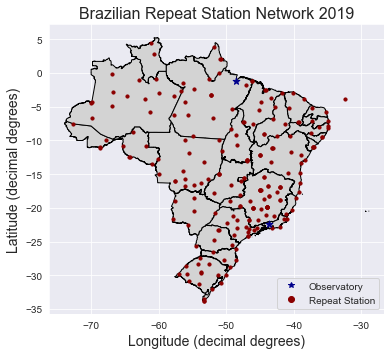

In [12]:
# Legend
blue_star = mlines.Line2D([], [], marker = obs_symbol_plot, color = obs_symbol_plot_color, linestyle='None',
                          markersize = 6, label = 'Observatory')
red_circle = mlines.Line2D([], [], marker = station_symbol_plot, color = station_symbol_plot_color, linestyle='None',
                          markersize = 6, label = 'Repeat Station')

# Create the figure
fig, ax = plt.subplots(figsize=(f1, f2))
#set aspect to equal. This is done automatically when using *geopandas* plot on it's own, but not when working with pyplot directly.
ax.set_aspect("equal")

# Plot
brazil_gdf.plot(ax = ax, color = brazil_color, edgecolor = brazil_edge_color)
repeat_stations_gdf.plot(ax = ax, marker = station_symbol_plot, color = station_symbol_plot_color, markersize = station_size, alpha = alpha_value)
obs_data_gdf.plot(ax = ax, marker = obs_symbol_plot, color = obs_symbol_plot_color, markersize = obs_size, alpha = alpha_value)
ax.legend(handles = [blue_star, red_circle], loc = leg_loc)

# Details
ax.set_title("Brazilian Repeat Station Network 2019", fontsize = title_size)
ax.set_xlabel("Longitude (decimal degrees)", fontsize = xlabel_size)
ax.set_ylabel("Latitude (decimal degrees)", fontsize = ylabel_size)
plt.savefig(output_folder / static_map, dpi = 300, bbox_inches = bbox_inches_value)
plt.show()
#plt.close()